<a href="https://colab.research.google.com/github/chihyanghsu0805/machine_learning/blob/tutorials/tutorials/tensorflow/autoencoder/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

##### Copyright 2020 The TensorFlow Authors.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import collections

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

This code follows the tutorial on https://www.tensorflow.org/tutorials/generative/autoencoder.

# Overview

# Overview
Autoencoders consist of two components, encoder and decoder.

The encoder decreases in size but increases in filters.

The bottleneck layer is the lowest layer and can be used as embeddings/ latent dimensions.

The decoder increases in size and decrease in filters.

Autoencoders can be used in various applications.

In this notebook, three applications were demonstrated.

1. Data Reconstruction/Compression
   
   The data can be represented using the latent dimension trained with identical input/output.

2. Denoising
   
   The denoised data can be restored by training with noist input and cleaned output.

3. Anomaly detection
   
   Outliers can be detected both supervised and unsupervised using mostly normal data.
   

# Load the dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Exploratory Data Analysis

Text(0.5, 1.0, 'Test Labels')

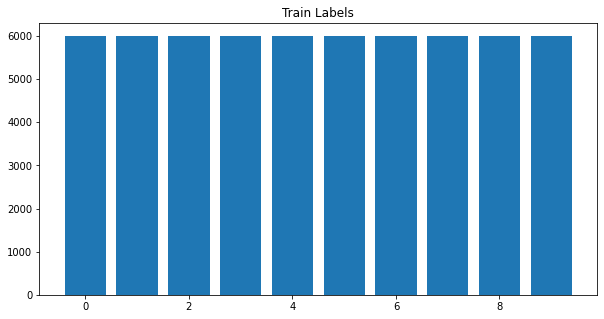

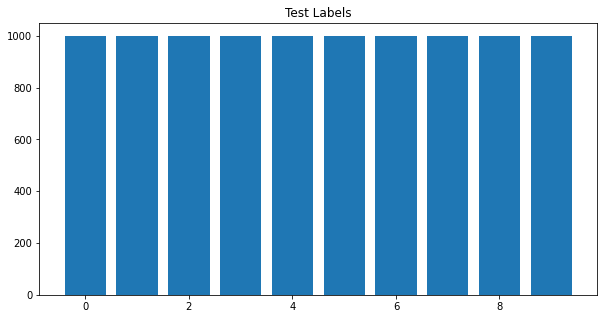

In [ ]:
plt.figure(figsize=(10,5))
y_train_count = collections.Counter(y_train)
plt.bar(y_train_count.keys(), y_train_count.values())
plt.title("Train Labels")

plt.figure(figsize=(10,5))
y_test_count = collections.Counter(y_test)
plt.bar(y_test_count.keys(), y_test_count.values())
plt.title("Test Labels")

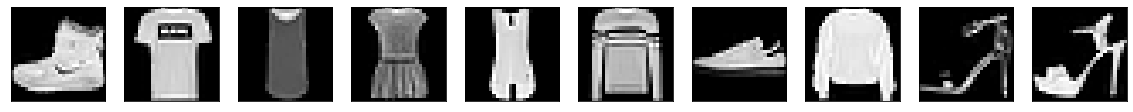

In [ ]:
labels = np.unique(np.concatenate([y_train, y_test]))
num_labels = len(labels)

plt.figure(figsize=(20, 4))
for i in labels:
    idx = y_train.tolist().index(i)
    ax = plt.subplot(1, num_labels, i + 1)
    plt.imshow(x_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


# Example 1: Reconstruction / Compression

## Data Preprocessing

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## Define Hyperparameters

In [ ]:
latent_dim = 64 
flatten_shape = 784
input_shape = (28, 28)

## Define the Autoencoder

In [ ]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(flatten_shape, activation='sigmoid'),
            layers.Reshape(input_shape)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Build the model

In [ ]:
compressor = Autoencoder(latent_dim) 

In [ ]:
compressor.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
compressor.fit(
    x_train,
    x_train,
    epochs=10,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/10
1875/1875 [==============================] - 13s 6ms/step - loss: 0.0237 - val_loss: 0.0132
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0115 - val_loss: 0.0105
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0099 - val_loss: 0.0096
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0094 - val_loss: 0.0093
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0091 - val_loss: 0.0090
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0087 - val_loss: 0.0088
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.

## Test the model

In [ ]:
encoded_imgs = compressor.encoder(x_test).numpy()
decoded_imgs = compressor.decoder(encoded_imgs).numpy()

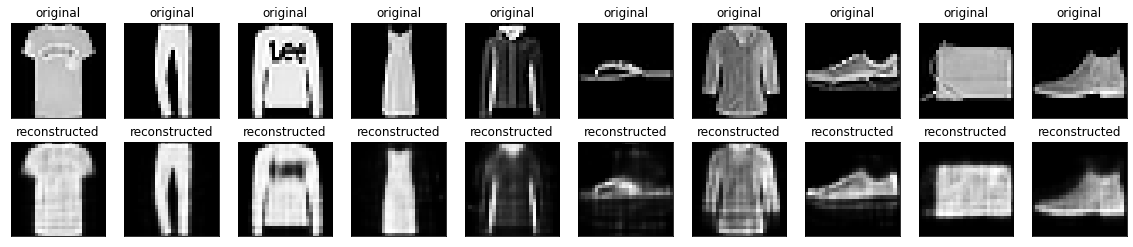

In [ ]:
plt.figure(figsize=(20, 4))

for i in labels:

    idx = y_test.tolist().index(i)

    # display original
    ax = plt.subplot(2, num_labels, i + 1)
    plt.imshow(x_test[idx])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, num_labels, i + 1 + num_labels)
    plt.imshow(decoded_imgs[idx])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


# Example 2: Denoising

In [ ]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

x_train_noisy = x_train_noisy[..., tf.newaxis]
x_test_noisy = x_test_noisy[..., tf.newaxis]

Plot the noisy images.


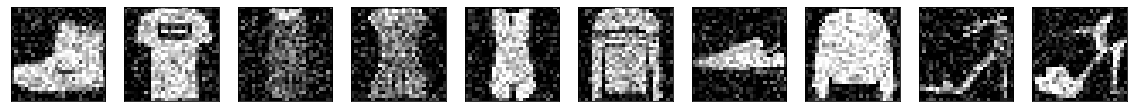

In [ ]:
plt.figure(figsize=(20, 4))
for i in labels:
    idx = y_train.tolist().index(i)
    ax = plt.subplot(1, num_labels, i + 1)
    plt.imshow(tf.squeeze(x_train_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


## Define the model

In [ ]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)
        ])

        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same'
        )])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Train the model

In [ ]:
denoiser = Denoise()

In [ ]:
denoiser.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
denoiser.fit(
    x_train_noisy,
    x_train,
    epochs=10,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)

Epoch 1/10
1875/1875 [==============================] - 13s 6ms/step - loss: 0.0166 - val_loss: 0.0096
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0087 - val_loss: 0.0081
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 4/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 6/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 7/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 8/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 9/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 10/10
1875/1875 [==============================] - 12s 6ms/step - l

# Test the model

In [ ]:
encoded_imgs = denoiser.encoder(x_test_noisy).numpy()
decoded_imgs = denoiser.decoder(encoded_imgs).numpy()

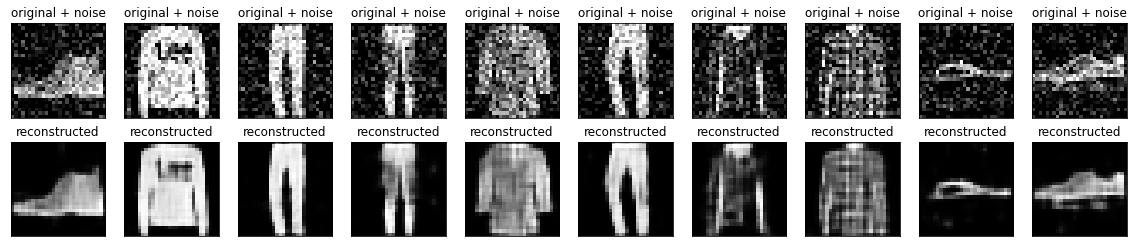

In [ ]:
plt.figure(figsize=(20, 4))
for i in range(num_labels):

    # display original + noise
    ax = plt.subplot(2, num_labels, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, num_labels, i + num_labels + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)


# Example 3: Anomaly detection

Autoencoders can be used for both supervised and unsupervised anomlay detection.


## Load ECG data

In [ ]:
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values

## Exploratory Data Analysis

In [ ]:
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


Text(0.5, 1.0, 'Class Distribution: all')

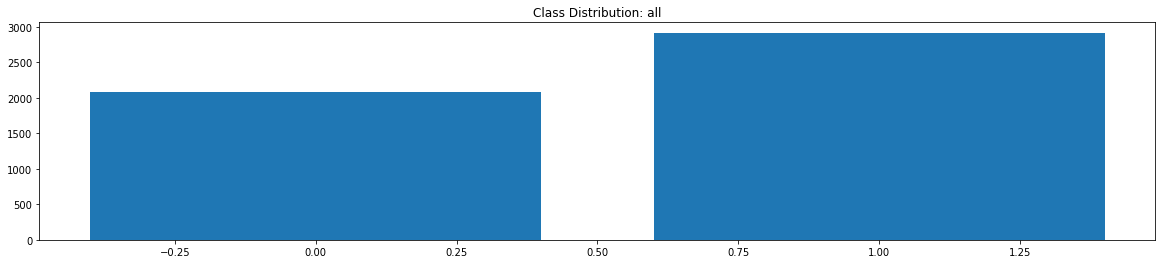

In [ ]:
# The last element contains the labels
labels = raw_data[:, -1]
labels_count = collections.Counter(labels)

plt.figure(figsize=(20, 4))
plt.bar(labels_count.keys(), labels_count.values())
plt.title(f"Class Distribution: all")

In [ ]:
# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [ ]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [ ]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

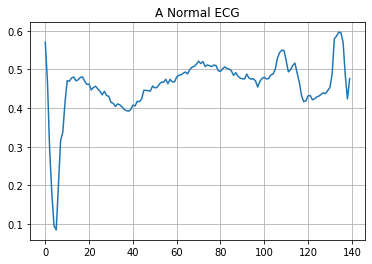

In [ ]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot an anomalous ECG.

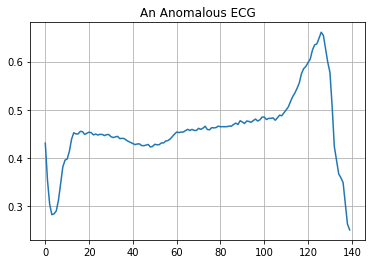

In [ ]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Build the model

In [ ]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")
        ])
    
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(140, activation="sigmoid")
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Train the model

In [ ]:
detector = AnomalyDetector()

In [ ]:
detector.compile(optimizer='adam', loss='mae')

In [ ]:
# Train only on normal
history = detector.fit(
    normal_train_data,
    normal_train_data,
    epochs=20, 
    batch_size=512,
    validation_data=(test_data, test_data),
    shuffle=True
)

Epoch 1/20
5/5 [==============================] - 1s 57ms/step - loss: 0.0584 - val_loss: 0.0533
Epoch 2/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0560 - val_loss: 0.0519
Epoch 3/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0537 - val_loss: 0.0504
Epoch 4/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0506 - val_loss: 0.0496
Epoch 5/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0474 - val_loss: 0.0480
Epoch 6/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0440 - val_loss: 0.0459
Epoch 7/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0408 - val_loss: 0.0443
Epoch 8/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0380 - val_loss: 0.0431
Epoch 9/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0358 - val_loss: 0.0421
Epoch 10/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0338 - val_loss: 0.0412
Epoch 11/20
5/5 [============

## Test the model

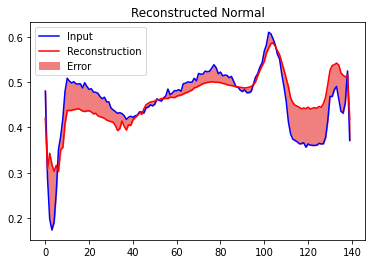

In [ ]:
encoded_data = detector.encoder(normal_test_data).numpy()
decoded_data = detector.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.title(f"Reconstructed Normal")
plt.show()

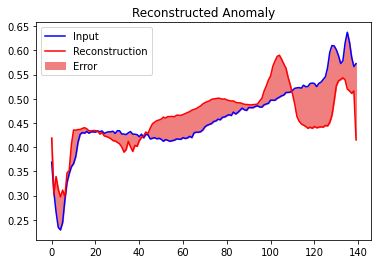

In [ ]:
encoded_data = detector.encoder(anomalous_test_data).numpy()
decoded_data = detector.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.title(f"Reconstructed Anomaly")
plt.show()

## Detect anomalies by selecting threshold of reconstruction error

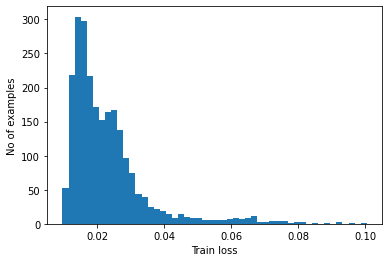

In [ ]:
reconstructions = detector.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print(f"Threshold: {threshold}")

Threshold: 0.03484371304512024


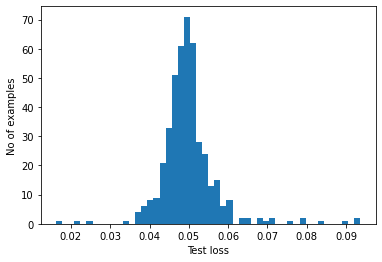

In [ ]:
reconstructions = detector.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [ ]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

In [ ]:
def print_stats(predictions, labels):
    print(f"Accuracy = {accuracy_score(labels, predictions)}")
    print(f"Precision = {precision_score(labels, predictions)}")
    print(f"Recall = {recall_score(labels, predictions)}")

In [ ]:
preds = predict(detector, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.944
Precision = 0.9921875
Recall = 0.9071428571428571
